In [1]:
# This cell for generating ood dataset
import random
import numpy as np
import os
from lib.utils import sliding_win
import matplotlib.pyplot as plt
import seaborn as sns

def generating_scenarios_dataset(data_dict, train_sc, save_mode=False):
    all_x, all_y = [], []
    for scenario in data_dict.keys():
        data = data_dict[scenario]
        x_offsets = np.sort(
                # np.concatenate(([-week_size + 1, -day_size + 1], np.arange(-11, 1, 1)))
                np.concatenate((np.arange(-11, 1, 1),))
            )
            # Predict the next one hour
        y_offsets = np.sort(np.arange(1, 13, 1))
        min_t = abs(min(x_offsets))
        max_t = abs(data.shape[0]- abs(max(y_offsets)))

        # max_t = abs(N - abs(max(y_offsets)))  # Exclusive
        x_train, y_train = [], []
        for t in range(min_t, max_t):
            x_t = data[t + x_offsets, ...]
            y_t = data[t + y_offsets, ...]
            if scenario in train_sc:
                x_train.append(x_t)
                y_train.append(y_t)
            # else:
            #     x_test.append(x_t)
            #     y_test.append(y_t)

        # divide train scenerio and test
        if scenario in train_sc:
            x_train = np.stack(x_train, axis=0)
            y_train = np.stack(y_train, axis=0)
            all_x.append(x_train)
            all_y.append(y_train)

    zipped_lists = list(zip(all_x, all_y))
    random.shuffle(zipped_lists)  # shuffle data
    all_x, all_y = zip(*zipped_lists)

    x = np.concatenate(all_x, axis=0)
    y = np.concatenate(all_y, axis=0)



    num_samples, num_nodes = x.shape[0], x.shape[2]  # num_samples = ts - 12*2 +1
    # len_train = round(num_samples * 0.8)
    # len_val = round(num_samples * 0.1)
    x_train, y_train = x, y
    # x_val, y_val = x[len_train:, ...], y[len_train:, ...]
    # x_test, y_test = np.concatenate(all_test_x, axis=0), np.concatenate(all_test_y, axis=0)

    if save_mode:
        for cat in ["train"]:
            _x, _y = locals()["x_" + cat], locals()["y_" + cat]
            np.savez_compressed(
            os.path.join("./scenarios_dataset", "%s.npz" % cat),
            x=_x,
            y=_y,
            # x_offsets=x_offsets.reshape(list(x_offsets.shape) + [1]),
            # y_offsets=y_offsets.reshape(list(y_offsets.shape) + [1]),
        )

In [2]:
import pandas as pd
parent_dir = './sc sensor/'

# Initialize an empty dictionary to hold the dataframes
df_dict = {}

# Loop through each subdirectory in the parent directory
for subdir, dirs, files in os.walk(parent_dir):
    # Initialize an empty list to hold the dataframes for this subdirectory
    df_list = []
    # Loop through each file in the subdirectory
    files.sort()
    for filename in files:
        # Check if the file is a CSV file
        if filename.endswith('.csv'):
            # Read the CSV file into a dataframe
            df = pd.read_csv(os.path.join(subdir, filename), sep="\t", index_col="Index")
            # Append the dataframe to the list
            col_name = os.path.splitext(filename)[0]
            # df_list.append(df['Sum'][:217].rename(col_name))
            flow_data = np.stack([df["Left to Right"].values, df["Right to Left"].values, df["Sum"].values], axis=1)
            df_list.append(pd.Series([row for row in flow_data], name = col_name))
            # df_list.append(df['Sum'].rename(col_name))
    # Concatenate all dataframes for this subdirectory into a single dataframe

    if df_list:
        df_concatenated = pd.concat(df_list, axis=1)
        # print(subdir)
        sorted_cols = sorted(df_concatenated.columns, key=lambda x: int(x.split('_')[1])) # sort the column name
        df_concatenated = df_concatenated.reindex(columns=sorted_cols)
        # Add the concatenated dataframe to the dictionary with the subdirectory name as the key
        df_dict[subdir] = df_concatenated

In [3]:
from lib.utils import gen_data_dict
from lib.utils import process_sensor_data
# Define path to parent directory containing subdirectories with CSV files
parent_dir = './sc sensor 2/'

# Loop through each subdirectory in the parent directory
df_dict = process_sensor_data(parent_dir, df_dict) # process sensor 2 data
data_dict = gen_data_dict(df_dict)

# ver 1
# train_sc = ["./sc sensor/sc1", "./sc sensor/sc2", "./sc sensor/sc2_2", "./sc sensor/sc3", "./sc sensor/sc3_2",
#             "./sc sensor/sc5", "./sc sensor/sc5_2", "./sc sensor/sc13", "./sc sensor/sc13_2", "./sc sensor 2/sc16",
#             "./sc sensor 2/sc18", "./sc sensor 2/sc19"]

# ver 2 # train domian test: sc16, sc20, sc13_2, sc5_2, sc3_2, test domain: 6_2, 7, 8, 10, 15
train_sc = ["./sc sensor/sc1", "./sc sensor/sc2", "./sc sensor/sc2_2", "./sc sensor/sc3", "./sc sensor/sc4_2",
            "./sc sensor/sc5", "./sc sensor/sc13",
            "./sc sensor 2/sc18", "./sc sensor 2/sc19"]

#ver 3 # include evacuation
# train_sc = ["./sc sensor/sc1", "./sc sensor/sc2", "./sc sensor/sc2_2", "./sc sensor/sc3", "./sc sensor/sc4_2",
#             "./sc sensor/sc5", "./sc sensor/sc13",
#             "./sc sensor 2/sc18", "./sc sensor 2/sc19", "./sc sensor 2/sc20", "./sc sensor 2/sc14", "./sc sensor 2/sc14_2"]
generating_scenarios_dataset(data_dict, train_sc, save_mode=False)

In [4]:
# Train an MLP
from sklearn.neural_network import MLPRegressor
step = 12
features = 3
num_nodes = 35
seq_len = 12
def load_dataset(dataset_dir):
    data = {}
    scalers = []
    for category in ['train']:
        cat_data = np.load(os.path.join(dataset_dir, category + '.npz'))
        data['x_' + category] = cat_data['x'].astype("float64")
        data['y_' + category] = cat_data['y'].astype("float64")

    return data

data = load_dataset("./scenarios_dataset")
train_X = data['x_train'].astype("float64").reshape([-1, step*features * num_nodes])
train_y = data['y_train'].astype("float64")
train_y = train_y[:, :seq_len, :,:].reshape([-1, step*features * num_nodes])

In [6]:
35*12*3

1260

In [42]:
# Train and Test
params_mlp = {"hidden_layer_sizes":(50, 50), "max_iter":500, "alpha":0.0001, "solver":'adam', "activation":"relu",
                   "verbose":True}
# params_mlp = {"hidden_layer_sizes":(128, 256, 128), "max_iter":500, "alpha":0.0001, "solver":'adam', "activation":"relu",
#                   "verbose":True}
model = MLPRegressor(**params_mlp, random_state=0)
# Fit the model to the training data
model.fit(train_X, train_y)

Iteration 1, loss = 45.16230871
Iteration 2, loss = 26.73255566
Iteration 3, loss = 23.11210384
Iteration 4, loss = 19.54099311
Iteration 5, loss = 16.59637024
Iteration 6, loss = 14.61146842
Iteration 7, loss = 13.19090860
Iteration 8, loss = 12.15286280
Iteration 9, loss = 11.43725047
Iteration 10, loss = 10.97516667
Iteration 11, loss = 10.64449117
Iteration 12, loss = 10.39324543
Iteration 13, loss = 10.17965504
Iteration 14, loss = 9.99635614
Iteration 15, loss = 9.81076071
Iteration 16, loss = 9.63882160
Iteration 17, loss = 9.45858609
Iteration 18, loss = 9.32419603
Iteration 19, loss = 9.17951426
Iteration 20, loss = 9.04462233
Iteration 21, loss = 8.91974385
Iteration 22, loss = 8.81013750
Iteration 23, loss = 8.72529259
Iteration 24, loss = 8.62657426
Iteration 25, loss = 8.57122724
Iteration 26, loss = 8.48640211
Iteration 27, loss = 8.42145004
Iteration 28, loss = 8.35437766
Iteration 29, loss = 8.30714240
Iteration 30, loss = 8.27542610
Iteration 31, loss = 8.21551839
Iter

MLPRegressor(hidden_layer_sizes=(50, 50), max_iter=500, random_state=0,
             verbose=True)

In [46]:
from lib.metric import masked_rmse_np, masked_mae_np, weighted_average_loss
output_dim = 3

vis_data = data_dict["./sc sensor 2/sc14"].astype("float64") # after sliding window
source, target = sliding_win(vis_data)  # process data into continuous sample data
# for i in range(3): #3 feature num
#     source[..., i] = data["scalers"][i].transform(source[..., i])  # input data
#     target[..., i] = data["scalers"][i].transform(target[..., i])  # ground truth

pred = model.predict(source.reshape(-1, num_nodes * output_dim * seq_len))
# vis = pred.reshape(-1, seq_len, num_nodes, output_dim)[:, step, node, feat]  # bc, steps, nodes, features
vis = pred.reshape(-1, seq_len, num_nodes, output_dim)  # bc, steps, nodes, features
# gt = target[:, step, node, feat]
gt = target
_, wt1, _ = weighted_average_loss(vis, gt, rho=0.9, timespan=3, mode=1)
_, wt2, _ = weighted_average_loss(vis, gt, rho=0.9, timespan=1, mode=0)
print(masked_mae_np(vis[..., 2], gt[..., 2]))
print(masked_rmse_np(vis[..., 2], gt[..., 2]))
print(np.mean(wt1[..., 2])) #wtrmse
print(np.mean(wt2[..., 2])) #wtmae

2.1221273
3.3837254
3.684414474634217
2.093399972624854


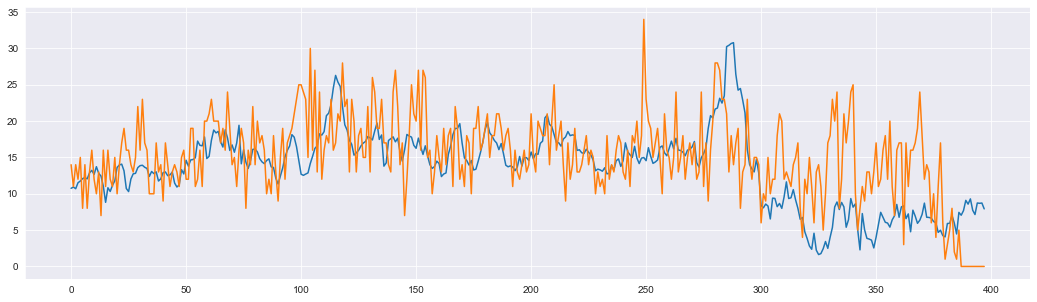

In [43]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(18, 5))
node = 0
steps = 1
plt.plot(vis[:, steps, node, 2])
plt.plot(gt[:, steps, node, 2])
plt.show()

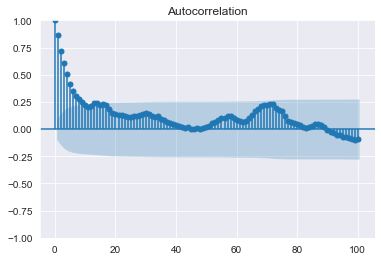

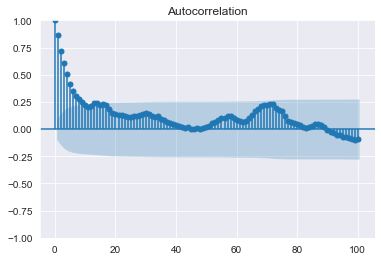

In [38]:
# Perform ACF analysis
feature = 2
node = 30
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(vis_data[:, node, feature], lags=100)

Text(0, 0.5, 'RMSE')

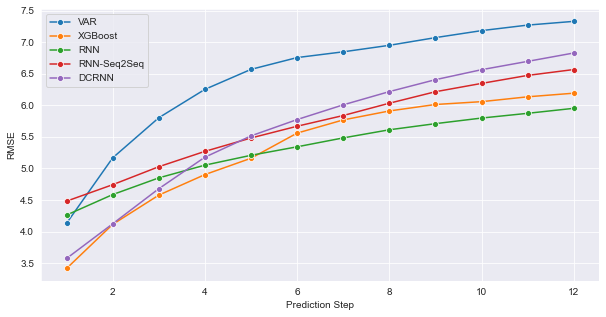

In [36]:
# Multi step prediction loss rmse ood
model_name = ["VAR", "XGBoost", "RNN", "RNN-Seq2Seq", "DCRNN"]
var = [4.1313562, 5.1680403, 5.8035345, 6.2533975, 6.5702395, 6.757124, 6.848223, 6.951371, 7.073284, 7.184205, 7.271753, 7.3309646]
xgboost = [3.4156651, 4.1140027, 4.577504, 4.902842, 5.1621056, 5.5604215, 5.769289, 5.9112806, 6.013674, 6.058585, 6.135492, 6.1928387]
rnn = [4.261774, 4.586212, 4.85075, 5.052631, 5.208602, 5.3431964, 5.4842134, 5.6129913, 5.7101674, 5.798809, 5.873883, 5.953061]
rnn_seq2seq = [4.482072, 4.742734, 5.027684, 5.2708716, 5.4830074, 5.669183, 5.839013, 6.0340414, 6.2160597, 6.347854, 6.474639, 6.56774]
dcrnn = [3.5736754, 4.1231484, 4.6789155, 5.1788373, 5.516384, 5.7748427, 6.0081086, 6.2179112, 6.4069653, 6.565208, 6.697112, 6.830036]

# sns line plot
plt.figure(figsize=(10, 5))
sns.lineplot(x=np.arange(1, 13), y=var, label="VAR", marker="o")
sns.lineplot(x=np.arange(1, 13), y=xgboost, label="XGBoost", marker="o")
sns.lineplot(x=np.arange(1, 13), y=rnn, label="RNN", marker="o")
sns.lineplot(x=np.arange(1, 13), y=rnn_seq2seq, label="RNN-Seq2Seq", marker="o")
sns.lineplot(x=np.arange(1, 13), y=dcrnn, label="DCRNN", marker="o")
plt.xlabel("Prediction Step")
plt.ylabel("RMSE")

Text(0, 0.5, 'MAE')

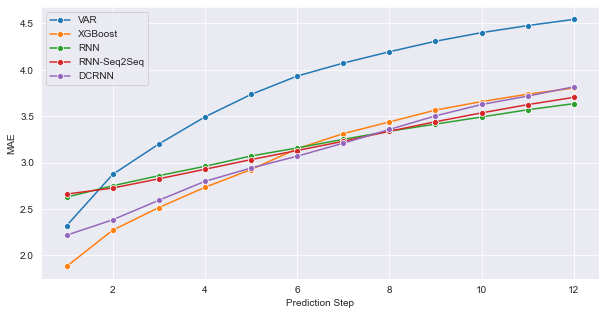

In [37]:
# Multi step prediction loss mae ood
var = [2.3200052, 2.872324, 3.2001953, 3.4925566, 3.7346935, 3.9326448, 4.0727143, 4.194646, 4.308154, 4.4010253, 4.47696, 4.544093]
xgboost = [1.8805745, 2.2715852, 2.5151687, 2.7334614, 2.9249787, 3.1489441, 3.3125656, 3.4381669, 3.5664012, 3.6575894, 3.7374816, 3.8043623]
rnn = [2.6278434, 2.7502387, 2.8589659, 2.9599993, 3.0712857, 3.1579466, 3.2508323, 3.3379772, 3.415122, 3.491672, 3.5694146, 3.635391]
rnn_seq2seq = [2.660535, 2.725886, 2.8251202, 2.9281507, 3.0322363, 3.1300929, 3.2295601, 3.3377302, 3.4405732, 3.5360556, 3.6247847, 3.7033963]
dcrnn = [2.2172413, 2.3834267, 2.593728, 2.79777, 2.9413376, 3.0691025, 3.2092566, 3.3568785, 3.5037515, 3.6263766, 3.7171962, 3.8166955]

# sns line plot
plt.figure(figsize=(10, 5))
sns.lineplot(x=np.arange(1, 13), y=var, label="VAR", marker="o")
sns.lineplot(x=np.arange(1, 13), y=xgboost, label="XGBoost", marker="o")
sns.lineplot(x=np.arange(1, 13), y=rnn, label="RNN", marker="o")
sns.lineplot(x=np.arange(1, 13), y=rnn_seq2seq, label="RNN-Seq2Seq", marker="o")
sns.lineplot(x=np.arange(1, 13), y=dcrnn, label="DCRNN", marker="o")
plt.xlabel("Prediction Step")
plt.ylabel("MAE")

## TSNE

In [23]:
s = data_dict['./sc sensor/sc11']
s = s.reshape([s.shape[0], -1])
s2 = data_dict['./sc sensor 2/sc16']
s2 = s2.reshape([s2.shape[0], -1])
s3 = data_dict['./sc sensor 2/sc18']
s3 = s3.reshape([s3.shape[0], -1])
s4 = data_dict['./sc sensor 2/sc14']
s4 = s4.reshape([s4.shape[0], -1])

/Users/mmai/anaconda3/envs/mps/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/mmai/anaconda3/envs/mps/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


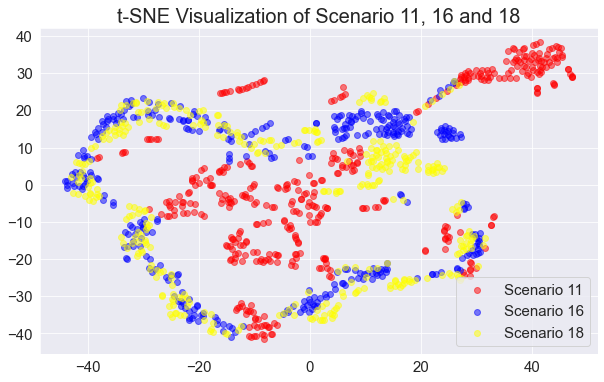

In [24]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
# n = 90
tsne = TSNE(n_components=2, random_state=42)
embedded_data = tsne.fit_transform(np.concatenate([s, s2, s3]))
# embedded_data = tsne.fit_transform(s)

# Create a scatter plot with colors based on the tags
plt.figure(figsize=(10, 6))
plt.scatter(
    embedded_data[:s.shape[0], 0], embedded_data[:s.shape[0], 1],
    label='Scenario 11', c='red', alpha=0.5
)


plt.scatter(
    embedded_data[s.shape[0]:(s.shape[0]+s2.shape[0]), 0], embedded_data[s.shape[0]:(s.shape[0]+s2.shape[0]), 1],
    label='Scenario 16', c='blue', alpha=0.5
)

plt.scatter(
    embedded_data[(s.shape[0]+s2.shape[0]):(s.shape[0]+s2.shape[0]+s3.shape[0]), 0], embedded_data[(s.shape[0]+s2.shape[0]):(s.shape[0]+s2.shape[0]+s3.shape[0]), 1],
    label='Scenario 18', c='yellow', alpha=0.5
)

# plt.scatter(
#     embedded_data[(s.shape[0]+s2.shape[0]+s3.shape[0]):(s.shape[0]+s2.shape[0]+s3.shape[0]+s4.shape[0]), 0], embedded_data[(s.shape[0]+s2.shape[0]+s3.shape[0]):(s.shape[0]+s2.shape[0]+s3.shape[0]+s4.shape[0]), 1],
#     label='Scenario 20', c='green', alpha=0.5
# )


plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.title('t-SNE Visualization of Scenario 11, 16 and 18', fontsize=20)
plt.legend(prop = {'size': 15})
# plt.savefig("./fig/3scenarios.pdf", bbox_inches='tight')
plt.show()

/Users/mmai/anaconda3/envs/mps/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/mmai/anaconda3/envs/mps/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


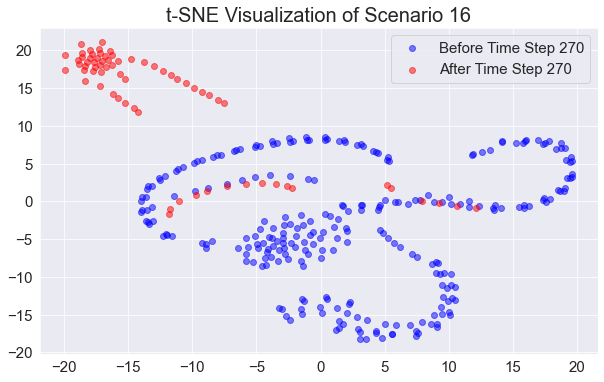

In [26]:
from sklearn.manifold import TSNE
n = 270
tsne = TSNE(n_components=2, random_state=42)
s2 = data_dict['./sc sensor 2/sc14']#.reshape([361, -1])
s_x, s_y = sliding_win(s2)
s_y = s_y[:, :6, :, :].reshape([s_y.shape[0], -1])
embedded_data = tsne.fit_transform(np.concatenate([s_y]))

# Create a scatter plot with colors based on the tags
plt.figure(figsize=(10, 6))

plt.scatter(
    embedded_data[:n, 0], embedded_data[:n, 1],
    label='Before Time Step 270', c='blue', alpha=0.5
)

plt.scatter(
    embedded_data[n:, 0], embedded_data[n:, 1],
    label='After Time Step 270', c='red', alpha=0.5
)

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.title('t-SNE Visualization of Scenario 16', fontsize=20)
plt.legend(prop = {'size': 15})
# plt.savefig("./fig/scenario18.pdf", bbox_inches='tight')
plt.show()


/Users/mmai/anaconda3/envs/mps/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/mmai/anaconda3/envs/mps/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


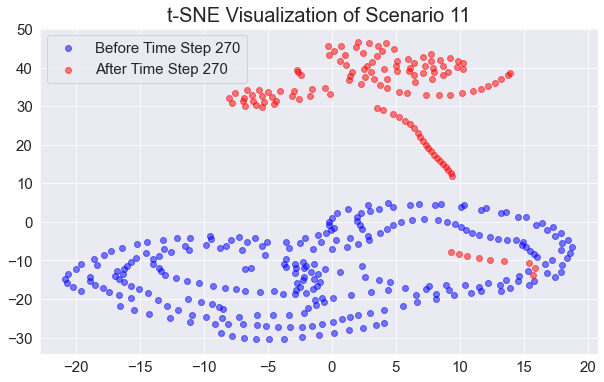

In [52]:
from sklearn.manifold import TSNE
s2 = data_dict['./sc sensor/sc11']
s_x, s_y = sliding_win(s2)
s_y = s_y[:, :6, :, :].reshape([s_y.shape[0], -1])
n = 270
tsne = TSNE(n_components=2, random_state=42)
embedded_data = tsne.fit_transform(np.concatenate([s_y]))
# embedded_data2 = tsne.fit_transform(s2)

# Create a scatter plot with colors based on the tags

plt.figure(figsize=(10, 6))
plt.scatter(
    embedded_data[:270, 0], embedded_data[:270, 1],
    label='Before Time Step 270', c='blue', alpha=0.5
)

plt.scatter(
    embedded_data[270:, 0], embedded_data[270:, 1],
    label='After Time Step 270', c='red', alpha=0.5
)

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.title('t-SNE Visualization of Scenario 11', fontsize=20)
plt.legend(prop = {'size': 15})
# plt.savefig("./fig/scenario11.pdf", bbox_inches='tight')
plt.show()


/Users/mmai/anaconda3/envs/mps/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/mmai/anaconda3/envs/mps/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


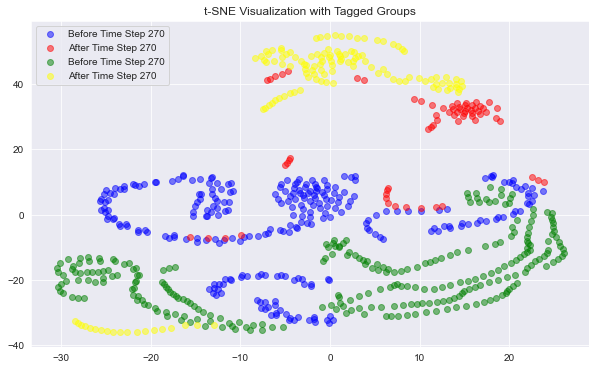

In [28]:
from sklearn.manifold import TSNE
s2 = data_dict['./sc sensor 2/sc14']
_, s_y = sliding_win(s2)
s_y = s_y[:, :6, :, :].reshape([s_y.shape[0], -1])
n = 270
tsne = TSNE(n_components=2, random_state=42)

s2 = data_dict['./sc sensor/sc11']
_, s_y2 = sliding_win(s2)
s_y2 = s_y2[:, :6, :, :].reshape([s_y2.shape[0], -1])


embedded_data = tsne.fit_transform(np.concatenate([s_y, s_y2]))

plt.figure(figsize=(10, 6))
plt.scatter(
    embedded_data[:270, 0], embedded_data[:270, 1],
    label='Before Time Step 270', c='blue', alpha=0.5
)

plt.scatter(
    embedded_data[270:s_y.shape[0], 0], embedded_data[270:s_y.shape[0], 1],
    label='After Time Step 270', c='red', alpha=0.5
)

plt.scatter(
    embedded_data[s_y.shape[0]:s_y.shape[0]+270, 0], embedded_data[s_y.shape[0]:s_y.shape[0]+270, 1],
    label='Before Time Step 270', c='green', alpha=0.5
)

plt.scatter(
    embedded_data[s_y.shape[0]+270:, 0], embedded_data[s_y.shape[0]+270:, 1],
    label='After Time Step 270', c='yellow', alpha=0.5
)

plt.title('t-SNE Visualization with Tagged Groups')
plt.legend()
plt.show()

In [36]:
data_dict['./sc sensor 2/sc14'].shape

(361, 35, 3)